# Graph-based model for HAN transportation

*Thảo Shibe - 22 April 2019*

### Workflow:
1. Xây dựng đồ thị cho mạng lưới giao thông tại HAN (**Done**)
1. Tính toán các metric về centrality trên đồ thị đã xây dựng (**On-going**)
1. So sánh các metric với nhu cầu thực tế

-----------------------------------
### Report 1: 8 April - 22 April/ 2019

##### Objective: Thiết lập graph-based model cho mạng lưới giao thông tại HAN

##### Key Results:

1. Xây dựng graph cho mạng lưới giao thông HAN (1/1)
1. Tính toán một số metric về centrality (1/1)
1. Visualization kết quả (graph vs graph+basemap) (0/1)

-------------------------------------------

(*Để tiện theo dõi, sẽ trình bày báo cáo kết quả 2 tuần làm việc và các khó khăn ngay tại đây*)

##### Done

1. *Đã xây dựng được đồ thị (vô hướng) cho hệ thống giao thông đường bộ tại HAN*
    - 237509 đỉnh
    - 261549 cạnh
    
1. *Đã thực hiện tính được một số metrics*:
    - Degree
    - Centrality

##### Challenging

1. Về packages:
    - igraph (đã cài đặt và sử dụng thử): Ban đầu sử dụng igraph, nhưng igraph không hỗ trợ xây dựng graph *theo vertex_id có sẵn* (igraph tự tạo vertex_id theo số lượng vertex). Điều này gây khó khăn với mong muốn giữ nguyên vertex_id là node_id trong CSDL OSM . (Tiện truy vấn lat, lon của vertex_id cho visualization sau này)
    - networkx (đã cài đặt và sử dụng thử): hỗ trợ vertex_id theo dữ liệu cho sẵn. Tuy nhiên, [***tốc độ tính toán của networkx kém hơn igraph rất nhiều***](https://graph-tool.skewed.de/performance)
    - graph-tool (chưa thử): lý do chưa thử cài đặt graph-tool do các dependent libraries của graph-tool rất nhiều (Boost, CGAL, etc.). Hơn nữa ***graph-tool không hỗ trợ cài đặt trực tiếp trên Window***

1. Tốc độ xử lý:
    - Xây dựng đồ thị: Qua nhiều lần thử nghiệm, hiện tại tốc độ xây dựng đồ thị cho mạng giao thông tại HAN là ~ 1h (giảm rất nhiều so với ý tưởng ban đầu là vét cạn, ~ 10h)
    - ***Tính các metrics*** hiện tại đang rất chậm (chỉ có tính degree là nhanh)

1. Visualization:
    - igraph/ networkz đều không hỗ trợ visualization cho đồ thị > 10k đỉnh. Vì vậy phải sử dụng **Gephi**
    - gephi: cần tìm hiểu thêm, hiện tại visual với Gephi còn nhiều hạn chế (do chưa biết sử dụng)
    

1. Bản thân:
    - Chưa đầu tư nhiều thời gian, **độ commit với công việc còn thấp**
    - Mất nhiều thời gian để cài đặt và tiếp cận packages mới

##### What's next:

1. **Tìm cách visualization**:
    - Đồ thị (chỉ có vertex và edge)
    - Đồ thị trên basemap (vertex, edge và bản đồ địa lý)

1. **Tính toán hiệu quả hơn với các metrics**:
    - Có thể phải tìm cách sử dụng kaggle kernel, google colab etc
    
    
    
![](https://cdn-images-1.medium.com/max/1600/1*Rf98vgvcLle1SZvLmmIwaQ.png)
    
![](https://vanishingcodes.files.wordpress.com/2015/06/final.jpeg)

-------------------------------------------

# Import Packages

In [17]:
import dill as pickle
from igraph import *
from tqdm import tqdm_notebook as tqdm
import numpy as np
import networkx as nx
from networkx import *
from matplotlib import pylab
import matplotlib.pyplot as plt

# Data

Sử dụng dữ liệu query từ OpenStreetMap, lấy tất cả các đường (ways) trong HAN (Notebook truy vấn dữ liệu "OSM")

In [28]:
with open('way.pkl', 'rb') as file:
    way = pickle.load(file)
with open('node.pkl', 'rb') as file:
    node = pickle.load(file)

Nói qua về dữ liệu OpenStreetMap, thì có 3 phần tử cơ bản:

- nodes (defining points in space)
- ways (defining linear features and area boundaries)
- relations (which are sometimes used to explain how other elements work together)

Tập trung vào dữ liệu dạng ways, vì dữ liệu thể hiện đường. Tuy nhiên, phải chú ý:
- Bỏ các closed_way: Vì thể hiện đường biên của một phân tử nào đó (hồ, toà nhà...)
- Bỏ các closed_way là sông?? (**chưa take cares bước này**)

# Contruct Graph

**Bài toán**: Xây dựng đồ thị G:
    - Mỗi giao điểm (intersection) là một đỉnh (node)
    - Hai đỉnh được nối với nhau nếu tồn tại một đường đi (way) qua chúng

**Input**:
    - Tập hợp các đường đi (ways)
    - Mỗi đường đi được biểu diễn bằng tập hợp điểm (node) được sắp thứ tự
    - Chú ý: Các node có thể không phải intersection/ Một ways có thể là closed_ways (mô tả đường biên, chứ không phải đường giao thông thực tế)
    
**Ý tưởng**: Intersection: List các giao điểm
    - Duyệt lần lượt các đường đi
        + Nếu là closed_ways thì bỏ qua (node đầu = node cuối)
        + Nếu không, tiếp tục bước dưới
    - Tại mỗi đường đi (way)
        + Thêm vào intersection các điểm chưa có
        + Nối lần lượt các node trong đường đi

In [36]:
g=nx.Graph()
intersection=[]
for i in tqdm(range(0, len(way.ways))):
    cur_node=way.ways[i]._node_ids
    # Check is ways is closed?
    if cur_node[0]==cur_node[-1]:
        pass
    else:
        # If in intersection: pass. If not in intersection: append
        g.add_nodes_from(np.setdiff1d(cur_node, intersection, assume_unique=True))
        intersection.extend(np.setdiff1d(cur_node, intersection, assume_unique=True))
        # Link nodes in ways
        for j in range(0, len(cur_node)-1):
            g.add_edge(cur_node[j], cur_node[j+1])
            
        # Sort intersection for faster search
        intersection.sort()

In [37]:
len(intersection)

237509

In [38]:
len(way.ways)

66388

***Không thể vẽ được đồ thị trong networkx vì hết RAM @@***

In [346]:
nx.draw_networkx(g)

MemoryError: 

#### Lưu các kết quả để tính toán

In [345]:
# Lưu đồ thị
import dill
filename='graph.pkl'
with open(filename, 'wb') as f:
    dill.dump(g, f)
    
# Lưu danh sách giao điểm
filename='intersection.pkl'
with open(filename, 'wb') as f:
    pickle.dump(intersection, f)

In [41]:
with open('graph.pkl', 'rb') as file:
    graph = read_gpickle(file)
#nx.write_gexf(graph, "graph.gexf")

In [24]:
len(graph.nodes)

237509

In [26]:
len(graph.edges)

261549

In [40]:
with open('intersection.pkl', 'rb') as file:
    intersection = pickle.load(file)
#nx.write_gexf(graph, "graph.gexf")

Thời gian chạy để tìm các intersection (cho ~66388 ways) là ~ 1,5 tiếng. Chưa có phương án tốt hơn để tăng tốc độ.

- 237509 giao điểm
- 237509 nodes
- 261549 cạnh

##### Visual một subgraph của đồ thị ban đầu

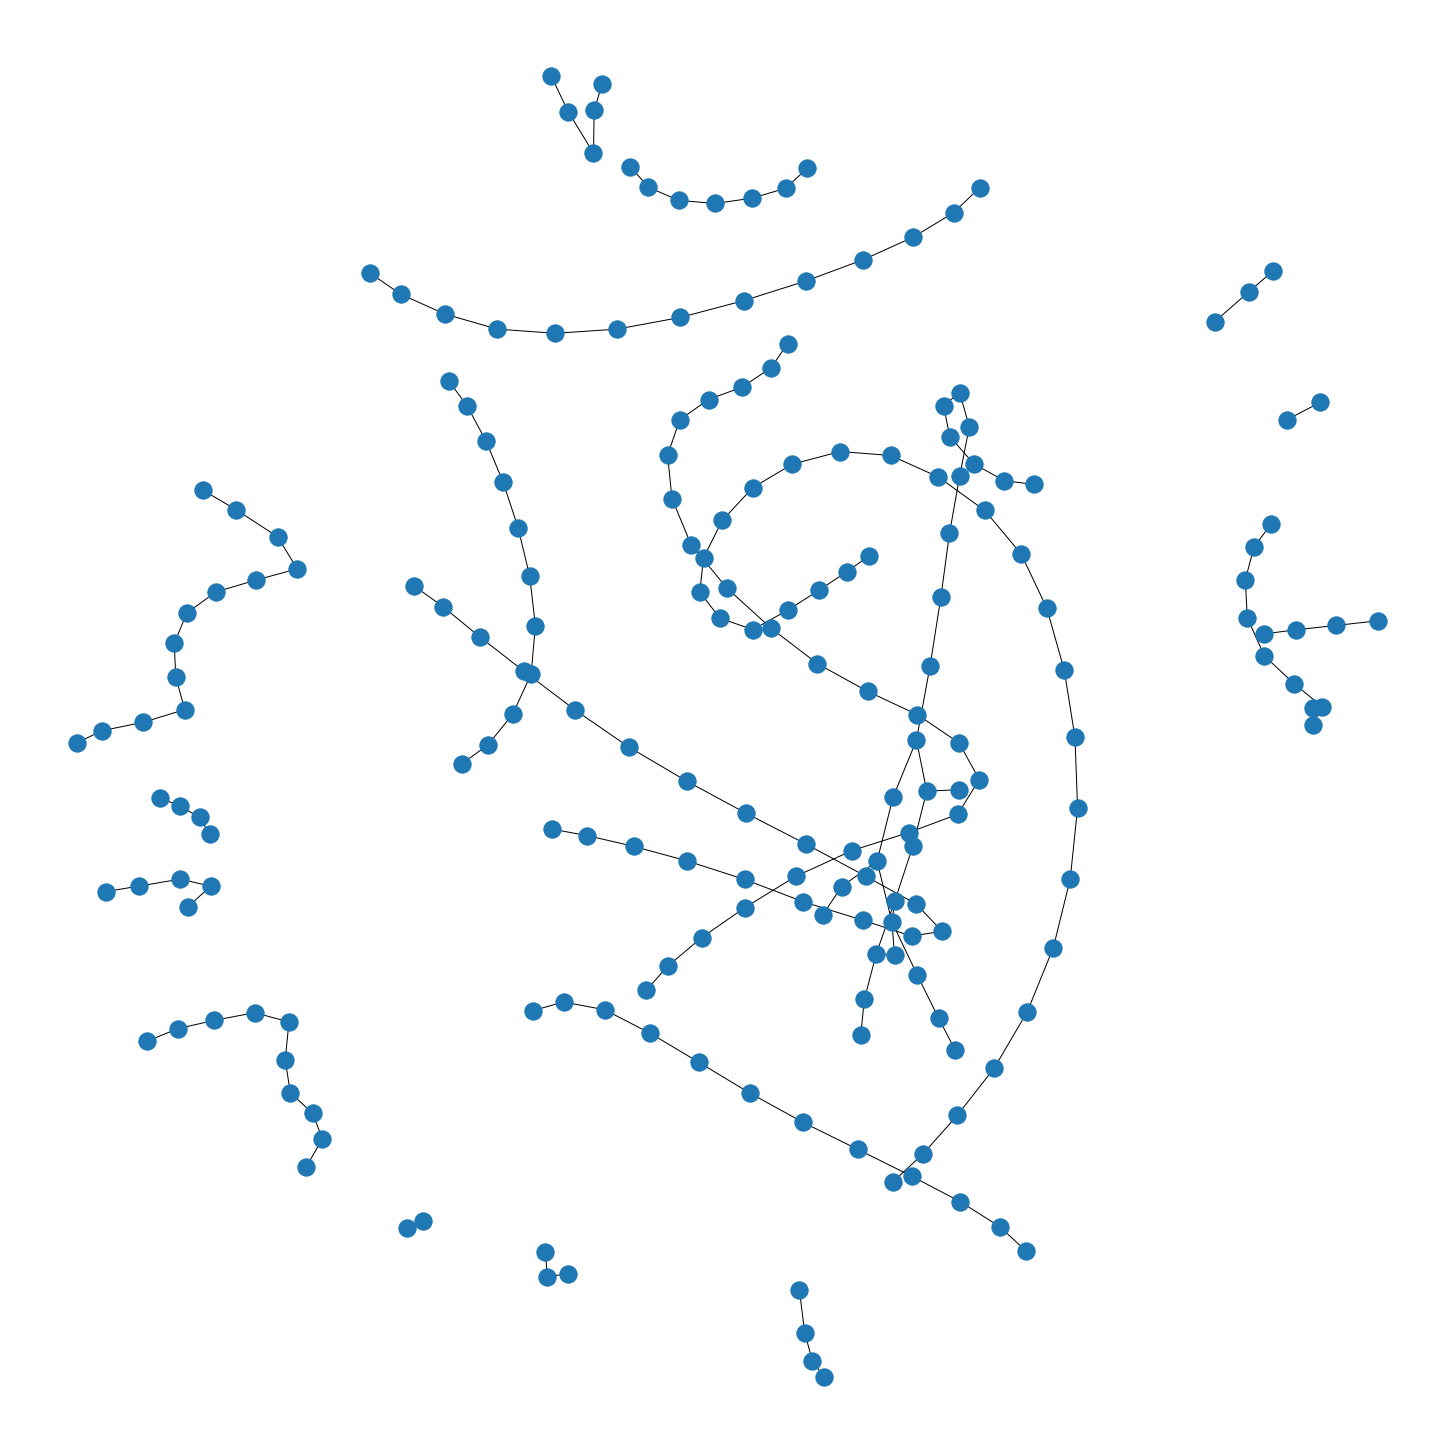

In [31]:
H = graph.subgraph([1893253381, 1893253440, 84786846, 84786849, 81794516, 75621001, 75620567, 103015876, 2964574849, 1954877847,
                    81799489, 81800150, 81800151, 2684248217, 2684248222,2684248232, 2684248237, 2684248250, 81800156, 2684248261,
                    2684248269, 81800158, 2684248290, 103062630, 4166712846,4166712856, 81804024, 81805393, 1893251833, 3776066607,
                    3776066606, 1884765798, 81806990, 102995903, 81806989, 102994445, 75617751, 4879616780, 317367071, 75618029,
                    439516577, 4900273922, 4900273921, 439516591, 81920051, 5721799555,4889653063, 5721658495, 4889653051, 439497868, 5719136236, 4025189859,
                    5719236749, 5719272597, 5449570867, 426893592, 91711681, 426897900, 426897907,
                    426891471, 5722388594, 5450253634, 82499297, 82501270, 426895178, 82500468, 82500427,
                    82500358, 82499298, 4495397169, 1495111445, 1495111449, 1495111451, 1495111446, 1495111443,
                    1495111442, 1495111440, 1495111439, 82500346, 1609148891, 82500347, 426891780, 82500350,
                    82500349, 1609148897, 1609148909, 4495453817, 82500348, 1609148903, 4495397180, 82510219,
                    436352393, 5686543919, 82510421, 82510422, 82526617, 5686543195, 5686543198, 82526618, 5671817215,
                    82526619, 82526621, 82526622, 82526623, 82526624, 82526625, 82526627, 5051722098, 436334350, 436334354,
                    5873236159, 5873236177, 5873236165, 5873236146, 436334310, 5873236142, 5873235965, 5873235959, 436334334,
                    5873235955, 5873235970, 436334319, 5873235946, 436334255, 5873235942, 436334316, 82535686, 3779523385, 3779523412, 82548775, 439440117, 82543196, 82543197, 4491345354, 4491345355,
                    5684248022, 82543198, 4491345356, 82543199, 82543200, 4491345357, 82543201, 4491345358, 82543202, 82543203, 4491345359, 82542101, 82542102, 4491345360, 82542103, 82542104, 4491345361, 82542106, 82541405, 82542510, 4491345368, 82542512, 4491345369, 82542513, 82542514, 4491345370, 82542515, 82542516, 4491345371, 82542517, 82542518, 4491345372, 82542519, 82542520, 4491345380, 1432317756, 4491345381, 1432317758, 1432317745, 4491355310, 4491355311, 4491355312, 4491355322, 4964033467, 4964033466, 82542413, 4491345378, 4491345363, 4491345362, 1432317730, 1432317767, 1432317757, 82547340, 3779526285, 5681643998, 82547341,
                    3779526284, 82547343, 82547345, 5686543356, 5683769942, 5683769936, 5683769938, 5683770053, 82538909, 1893260873, 5683770174, 82538912, 82538913, 82538914])
# 3776066606, 1884765798, 81806990, 102995903, 81806989, 102994445, 75617751, 4879616780, 317367071, 75618029, 439516577, 4900273922, 4900273921, 439516591, 81920051, 5721799555, 4889653063, 5721658495, 4889653051, 439497868, 5719136236, 4025189859, 5719236749, 5719272597, 5449570867, 426893592, 91711681, 426897900, 426897907, 426891471, 5722388594, 5450253634, 82499297, 82501270, 426895178, 82500468, 82500427, 82500358, 82499298, 4495397169, 1495111445, 1495111449, 1495111451, 1495111446, 1495111443, 1495111442, 1495111440, 1495111439, 82500346, 1609148891, 82500347, 426891780, 82500350, 82500349, 1609148897, 1609148909, 4495453817, 82500348, 1609148903, 4495397180, 82510219, 436352393, 5686543919, 82510421, 82510422, 82526617, 5686543195, 5686543198, 82526618, 5671817215, 82526619, 82526621, 82526622, 82526623, 82526624, 82526625, 82526627, 5051722098, 436334350, 436334354, 5873236159, 5873236177, 5873236165, 5873236146, 436334310, 5873236142, 5873235965, 5873235959, 436334334, 5873235955, 5873235970, 436334319, 5873235946, 436334255, 5873235942, 436334316, 82535686, 3779523385, 3779523412, 82548775, 439440117, 82543196, 82543197, 4491345354, 4491345355, 5684248022, 82543198, 4491345356, 82543199, 82543200, 4491345357, 82543201, 4491345358, 82543202, 82543203, 4491345359, 82542101, 82542102, 4491345360, 82542103, 82542104, 4491345361, 82542106, 82541405, 82542510, 4491345368, 82542512, 4491345369, 82542513, 82542514, 4491345370])
plt.figure(figsize=(20, 20))
nx.draw(H)

# Metrics

In [9]:
with open('graph.pkl', 'rb') as file:
    graph = read_gpickle(file)
#nx.write_gexf(graph, "graph.gexf")

### Degree

In [10]:
degree_centrality=degree_centrality(graph)

In [12]:
len(degree_centrality)

237509

### Betweeness

In [15]:
%%time
closeness=closeness_centrality(graph)

KeyboardInterrupt: 

In [16]:
%%time
betweenness=betweenness_centrality(graph)

KeyboardInterrupt: 

In [ ]:
%%time
edge_betweeness=edge_betweenness_centrality(graph)

In [ ]:
### Closeness